# Image Segmentation

This notebook is adapted from this Keras Competition: [Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018)

https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook

From the competition [Data Section](https://www.kaggle.com/c/data-science-bowl-2018/data) download the file `stage1_train.zip` and `stage1_test.zip`, unzip it, make it available somewhere in the file system and update the `TRAIN_PATH` and `TEST_PATH` variables accordingly below.



# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
!pip install tqdm
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '/home/rlx/Downloads/input/stage1_train/'
TEST_PATH = '/home/rlx/Downloads/input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

Observe some image sizes and their variability

In [3]:
for n, id_ in enumerate(np.random.permutation(train_ids)[:10]):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    print img.shape

(256, 256, 3)
(1024, 1024, 3)
(256, 320, 3)
(256, 320, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 320, 3)
(256, 256, 3)
(520, 696, 3)


In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:46<00:00, 19.07it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 140.33it/s]

Done!


In [5]:
X_train.shape, Y_train.shape

((670, 128, 128, 3), (670, 128, 128, 1))

Let's see if things look all right by drawing some random images and their associated masks.

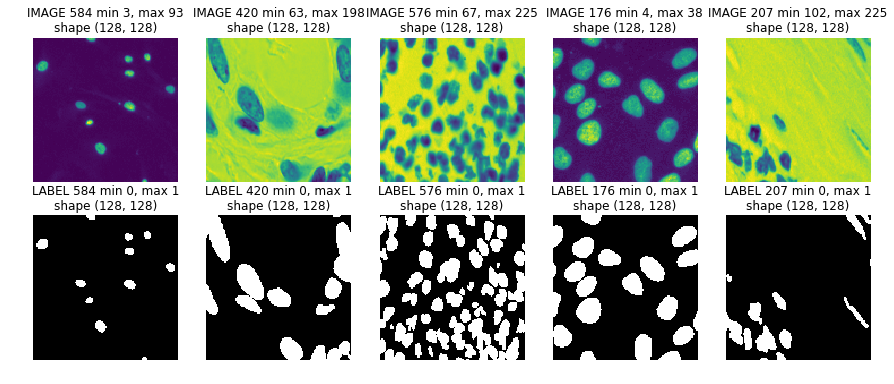

In [6]:
def show_img(img, title="", cmap=None, details=True):
    plt.imshow(img, cmap=cmap)
    if details:
        plt.title("%s min %d, max %d\nshape %s"%(title, np.min(img), np.max(img), str(img.shape)))
    else:
        plt.title(title)
    plt.axis("off")
    
plt.figure(figsize=(15,6))
ids = np.random.permutation(len(X_train))[:5]
for c,i in enumerate(ids):
    plt.subplot(2,5,c+1)
    show_img(X_train[i].mean(axis=2), "IMAGE %d"%i)
    plt.subplot(2,5,c+6)
    show_img(np.squeeze(Y_train[i]), "LABEL %d"%i, cmap=plt.cm.Greys_r)

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [8]:
def get_model():
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    
    return model

In [9]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

### you may skip this step by downloading directly the pretrained weights

In [21]:
!wget -nc https://s3.amazonaws.com/rlx/model-dsbowl2018-1.h5

File ‘model-dsbowl2018-1.h5’ already there; not retrieving.



In [10]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
576/603 [===========================>..] - ETA: 0s - loss: 5.4154 - mean_iou: 0.4444
Epoch 00001: val_loss improved from inf to 2.67058, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 5s 9ms/step - loss: 5.2931 - mean_iou: 0.4480 - val_loss: 2.6706 - val_mean_iou: 0.5324
Epoch 2/50
592/603 [============================>.] - ETA: 0s - loss: 2.4783 - mean_iou: 0.5888
Epoch 00002: val_loss improved from 2.67058 to 2.12630, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 1s 2ms/step - loss: 2.4609 - mean_iou: 0.5896 - val_loss: 2.1263 - val_mean_iou: 0.6343
Epoch 3/50
592/603 [============================>.] - ETA: 0s - loss: 2.0286 - mean_iou: 0.6601
Epoch 00003: val_loss improved from 2.12630 to 1.61469, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 1s 2ms/step - loss: 2.0072 - mean_iou: 0.6605 - val_loss: 1.6147 - val_mean_iou: 0.6

Epoch 28/50
592/603 [============================>.] - ETA: 0s - loss: 1.1151 - mean_iou: 0.8341
Epoch 00028: val_loss did not improve from 0.88542
603/603 [==============================] - 1s 2ms/step - loss: 1.1120 - mean_iou: 0.8341 - val_loss: 0.9006 - val_mean_iou: 0.8348
Epoch 29/50
592/603 [============================>.] - ETA: 0s - loss: 1.0609 - mean_iou: 0.8355
Epoch 00029: val_loss did not improve from 0.88542
603/603 [==============================] - 1s 2ms/step - loss: 1.0560 - mean_iou: 0.8355 - val_loss: 0.8889 - val_mean_iou: 0.8362
Epoch 30/50
592/603 [============================>.] - ETA: 0s - loss: 1.0565 - mean_iou: 0.8368
Epoch 00030: val_loss did not improve from 0.88542
603/603 [==============================] - 1s 2ms/step - loss: 1.0556 - mean_iou: 0.8368 - val_loss: 0.9438 - val_mean_iou: 0.8374
Epoch 31/50
592/603 [============================>.] - ETA: 0s - loss: 1.0378 - mean_iou: 0.8380
Epoch 00031: val_loss did not improve from 0.88542
603/603 [======

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [22]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 475us/step


In [14]:
int(X_train.shape[0]*0.9), len(X_train)

(603, 670)

## performance on validation data

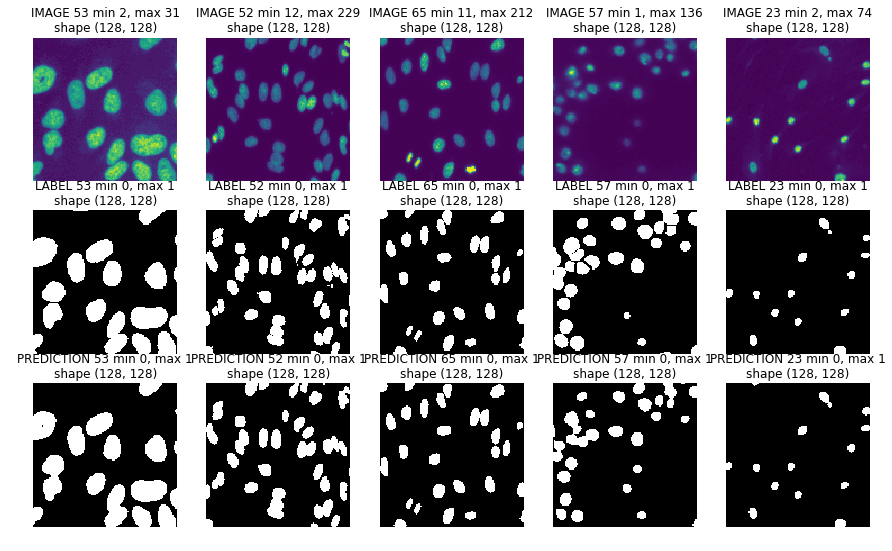

In [15]:
plt.figure(figsize=(15,9))
ids = np.random.permutation(len(preds_val))[:5]
for c,i in enumerate(ids):
    plt.subplot(3,5,c+1)
    show_img(X_train[int(X_train.shape[0]*0.9):][i].mean(axis=2), "IMAGE %d"%i)
    plt.subplot(3,5,c+6)
    show_img(np.squeeze(Y_train[int(X_train.shape[0]*0.9):][i]), "LABEL %d"%i, cmap=plt.cm.Greys_r)
    plt.subplot(3,5,c+11)
    show_img(np.squeeze(preds_val_t[i]), "PREDICTION %d"%i, cmap=plt.cm.Greys_r)

## And on test data

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

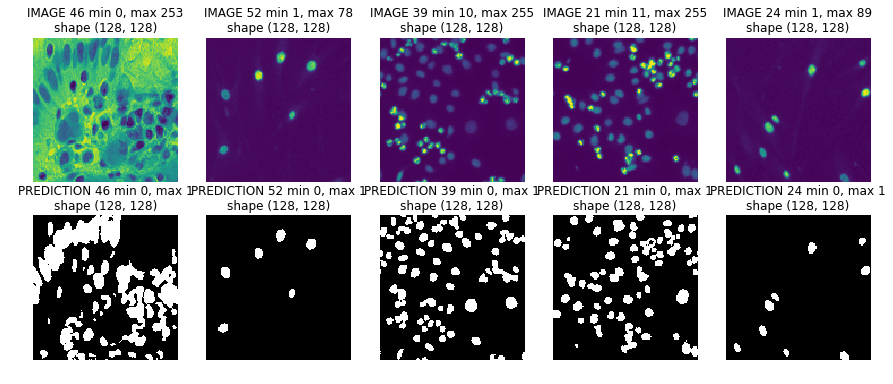

In [20]:
plt.figure(figsize=(15,6))
ids = np.random.permutation(len(preds_test))[:5]
for c,i in enumerate(ids):
    plt.subplot(2,5,c+1)
    show_img(X_test[i].mean(axis=2), "IMAGE %d"%i)
    plt.subplot(2,5,c+6)
    show_img(np.squeeze(preds_test_t[i]), "PREDICTION %d"%i, cmap=plt.cm.Greys_r)